In [1]:
import numpy as np
import matplotlib.pyplot as plt
import get_files
import pandas as pd
import pyarrow.parquet as pq



In [2]:
count_source = pq.read_table('Communication_graph_counts.parquet',
                               columns=['Source', 'counts']).to_pandas()
count_source.counts.describe()

count    100000.000000
mean       1134.258190
std        1048.109632
min         186.000000
25%         504.000000
50%         810.000000
75%        1393.000000
max       38316.000000
Name: counts, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f450f2e6450>],
      dtype=object)

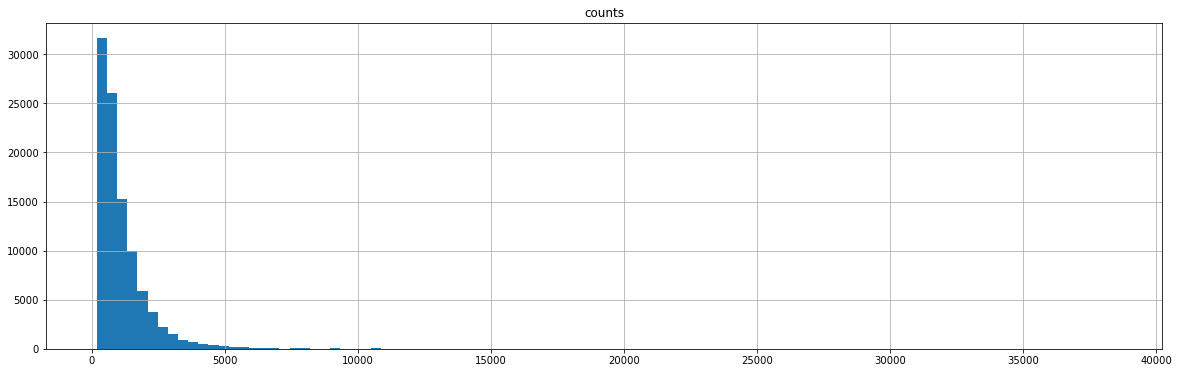

In [3]:
fig, ax = plt.subplots(figsize=(20,6))
count_source.hist(ax=ax, bins=100)
# ax.set_yscale('log')


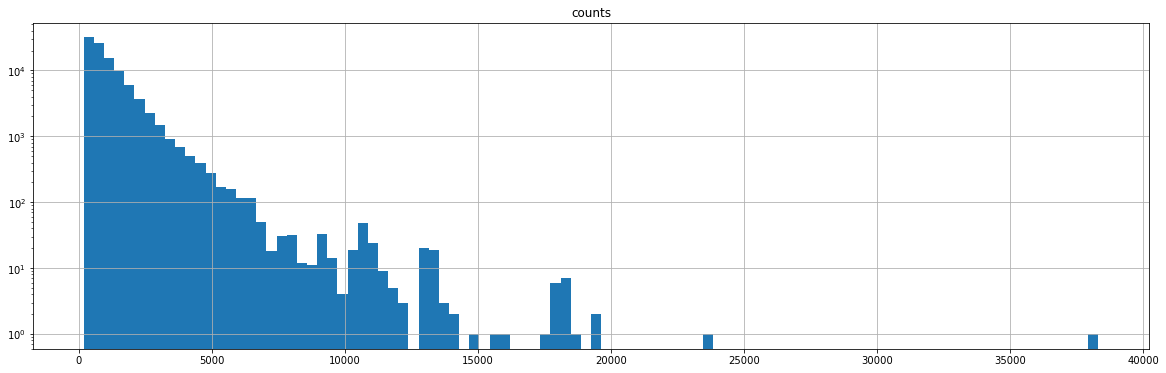

In [4]:
fig, ax = plt.subplots(figsize=(20,6))
count_source.hist(ax=ax, bins=100)
ax.set_yscale('log')

In [5]:
count_target = pq.read_table('Communication_graph_counts_target.parquet',
                               columns=['Target', 'counts']).to_pandas()
count_target.describe()

counts
count  100000.000000
mean     1134.258190
std       801.211561
min       195.000000
25%       682.000000
50%       919.000000
75%      1310.000000
max     45919.000000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4500cc3610>],
      dtype=object)

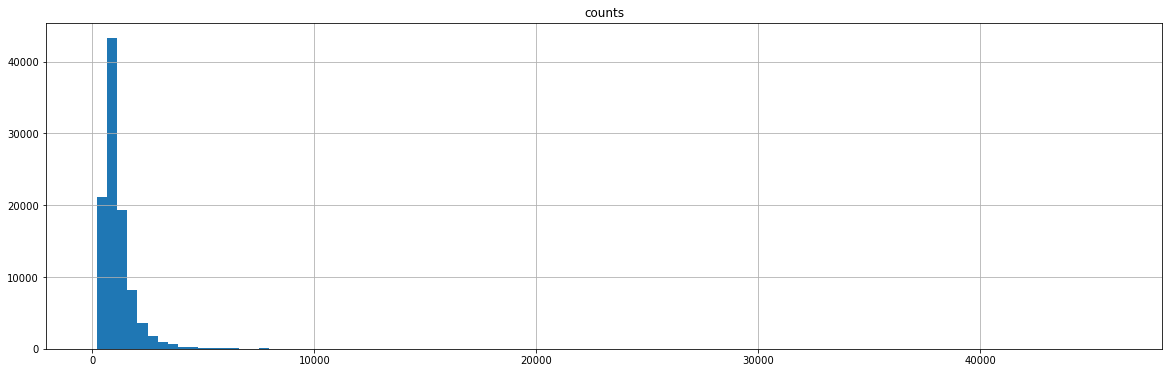

In [6]:
fig, ax = plt.subplots(figsize=(20,6))
count_target.hist(ax=ax, bins=100)

In [7]:
fig, ax = plt.subplots(figsize=(20,6))
count_target.hist(ax=ax, bins=100)
ax.set_yscale('log')

In [7]:
def get_edges():
    filename = 'Communication_graph.parquet'
    edges = pq.read_table(filename,
                               columns=['Source', 'Target']).to_pandas()
    edges = edges.astype('int32', copy=False)
    return edges

def save_to_parquet():
    com_mat = get_files.get_communication_matrix()
    # edge_pos = np.asarray([(xy[i], xy[j]) for i, j in zip(com_mat.row, com_mat.col) ])
    edges = pd.DataFrame(zip(com_mat.row, com_mat.col, com_mat.data),
                         columns=['Source', 'Target', 'Weight'], dtype=np.int32)
#     edges = edges.astype('int32', copy=False)
    edges.set_index('Source')
    edges.to_parquet('Communication_graph.parquet', engine='pyarrow')
    
def save_counts_source():
    edges = get_edges()
    count_source = edges.groupby(['Source']).size().to_frame(name='counts')
    count_source = count_source.astype('int32', copy=False)
    count_source.to_parquet('Communication_graph_counts.parquet', engine='pyarrow')

def save_counts_target():
    edges = get_edges()
    count_target = edges.groupby(['Target']).size().to_frame(name='counts')
    count_target = count_target.astype('int32', copy=False)
    count_target.to_parquet('Communication_graph_counts_target.parquet', engine='pyarrow')

In [23]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import connect_edges, hammer_bundle


cvsopts = dict(plot_height=1000, plot_width=1000)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.shade(agg, cmap=["darksalmon"], name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None, xr=None, yr=None):
    if canvas is None:
        if xr is None:
            xr = nodes.x.min(), nodes.x.max()
        if yr is None:
            yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


In [8]:
edges = get_edges()

In [ ]:
edges = edges[edges.Weight > 2]
edges.rename(columns={'Source': 'source', 'Target': 'target'}, inplace=True)
edges.shape


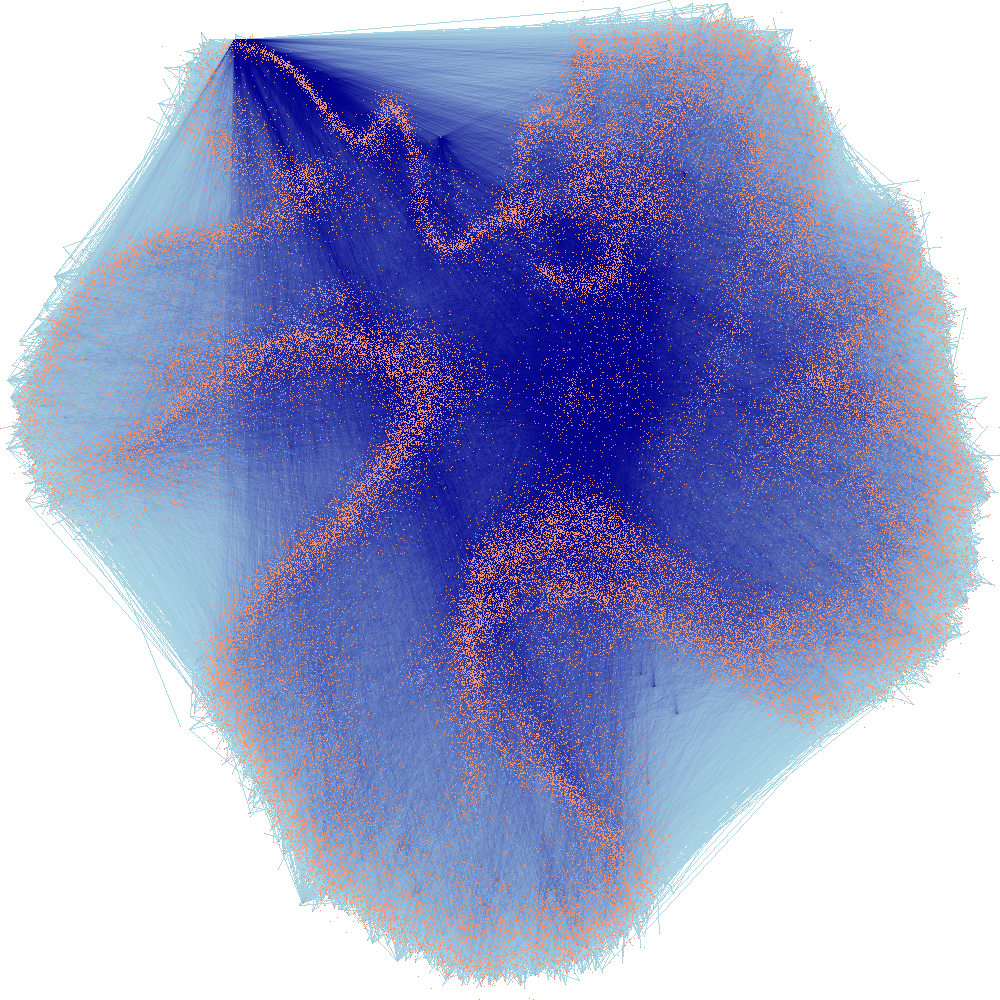

In [21]:
xy = np.load('umap_embedding.npy')
nodes = pd.DataFrame(data=xy, columns=['x', 'y'])
umap_nodes = graphplot(nodes, connect_edges(nodes, edges), "Umap layout")
tf.Images(umap_nodes)

In [25]:
xy = np.load('spec_embedding_e.npy')
fig, ax = plt.subplots(figsize=(20,20)) #plt.figure()
ax.scatter(xy[:,0], xy[:,1], s=0.1)
ax.set_xlim(np.max(xy[:,0])-10e-15, np.max(xy[:,0]))
ax.set_ylim(np.min(xy[:,1])-10e-6, np.min(xy[:,1])+15e-4)

(-3.18587210475154e-05, 0.0014781412789524847)

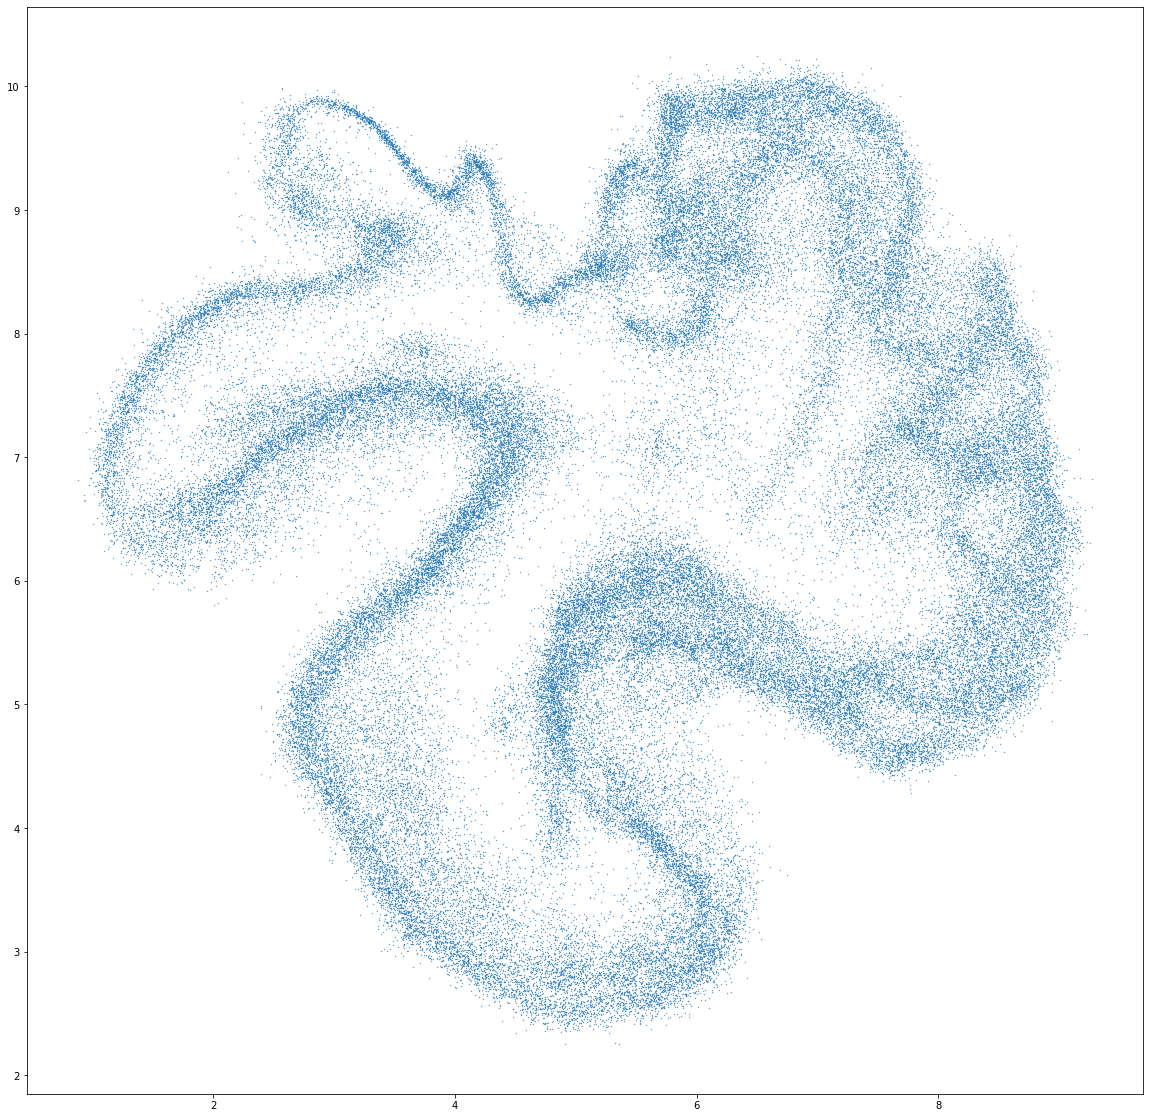

In [4]:
xy = np.load('umap_embedding.npy')
plt.figure(figsize=(20,20))
plt.scatter(xy[:,0], xy[:,1], s=0.1)

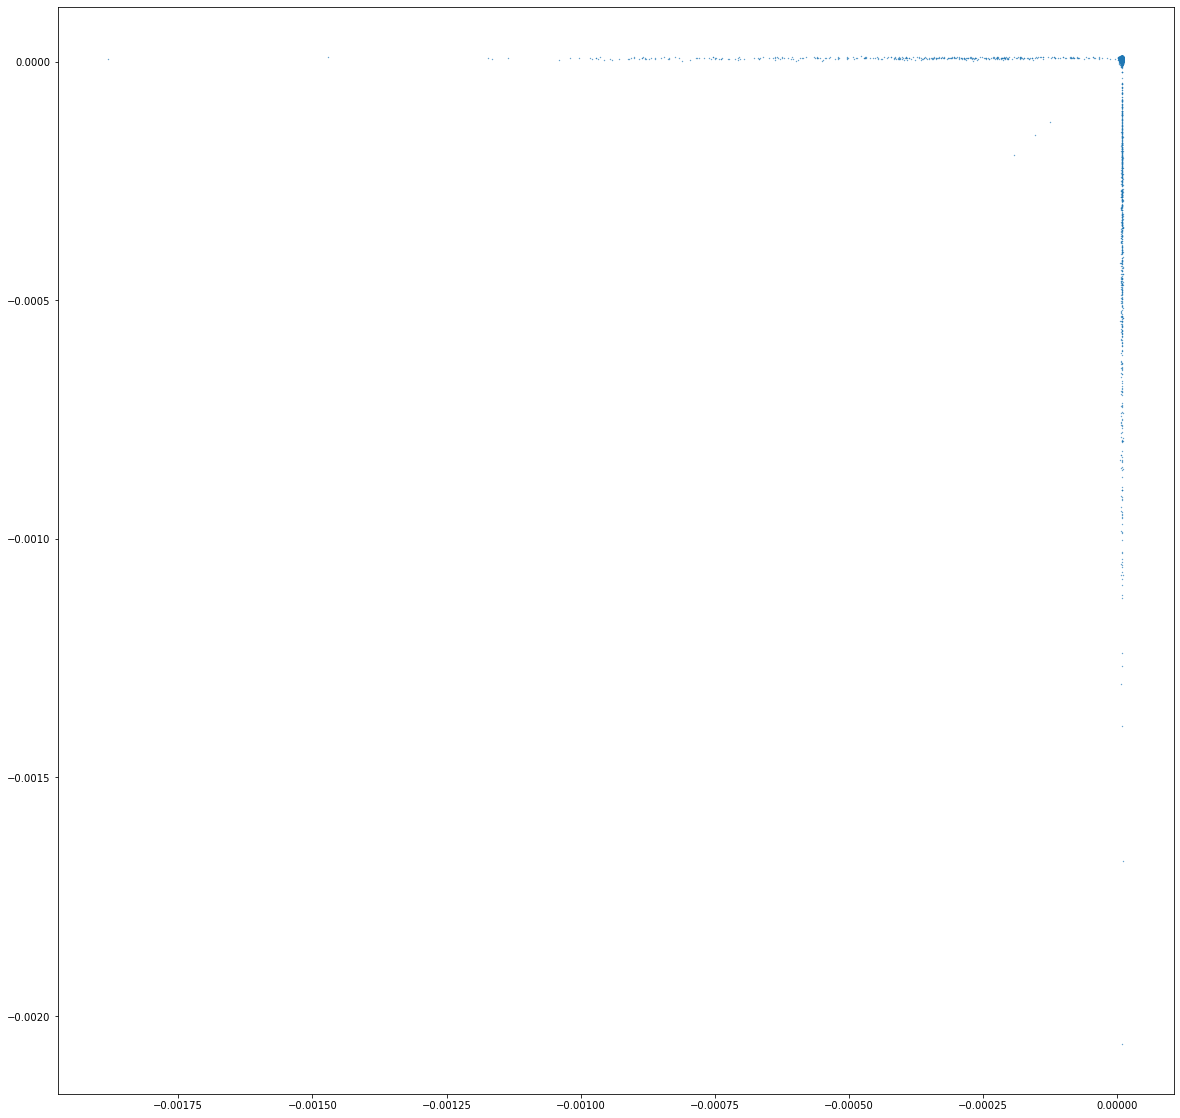

In [5]:
xy = np.load('spec_embedding.npy')
plt.figure(figsize=(20,20))
plt.scatter(xy[:,0], xy[:,1], s=0.1)

In [6]:
xy = np.load('spring_embedding.npy')
plt.figure(figsize=(20,20))
plt.scatter(xy[:,0], xy[:,1], s=0.1)